In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist
from sklearn.metrics import mean_squared_error,accuracy_score

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('Churn_Modelling.csv')
x = dataset.iloc[:,3:13].values
y = dataset.iloc[:,13].values

#Encoding 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
labelencoder_x_1 = LabelEncoder()
x[:,1] = labelencoder_x_1.fit_transform(x[:,1])
labelencoder_x_2 =  LabelEncoder()
x[:,2] = labelencoder_x_2.fit_transform(x[:,2])
onehotencoder = OneHotEncoder(categorical_features=[1])
x = onehotencoder.fit_transform(x).toarray()
x = x[:,1:]

#split train test data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=.25,random_state=0)

#scale the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [3]:
y_train= y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [4]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z)),Z

In [5]:
def relu(Z):
    return np.maximum(0,Z),Z

In [6]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    dZ[Z <= 0] = 0  
    return dZ

In [7]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [8]:

def intialize_deep_para(layer_dim):
    para = {}
    for i in range(1,len(layer_dim)):
        para["W"+str(i)] = np.random.randn(layer_dim[i],layer_dim[i-1])*0.01
        para["b"+str(i)] = np.zeros((layer_dim[i],1))
    return para

In [9]:
def linear_forward(A,W,b):
    z = np.dot(W,A) + b
    cache = (A,W,b)
    return z,cache

In [10]:
def linear_activaton_fordward_propagation(A_prev,W,b,activation):
    if activation == "sigmoid":
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z,linear_cache = linear_forward(A_prev,W,b)
        A,activation_cache = relu(Z)
    cache = (linear_cache,activation_cache)
    return A,cache
    

In [11]:
def L_model_forward(X,para):
    L = len(para)//2 
    caches = []
    A = X
    for i in range(1,L):
        A_prev = A
        A,cache = linear_activaton_fordward_propagation(A_prev,para["W"+str(i)],para["b"+str(i)],activation="relu")
        caches.append(cache)
    
    AL,cache = linear_activaton_fordward_propagation(A,para["W"+str(L)],para["b"+str(L)],activation="sigmoid")
    caches.append(cache)
    return AL,caches    

In [12]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T)/m
    db = np.sum(dZ, axis=1, keepdims=True)/m
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

In [13]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)    
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [14]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL =  - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    current_cache = caches[L-1]
    grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)]=linear_activation_backward(dAL,current_cache,activation="sigmoid")
    for i in reversed(range(L-1)):
        current_cache = caches[i]
        grads["dA"+str(i)],grads["dW"+str(i+1)],grads["db"+str(i+1)] = linear_activation_backward(grads["dA"+str(i+1)],current_cache,activation="relu")
    return grads

In [15]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost =(-1 / m) * np.sum(np.multiply(Y, np.log(AL)) + np.multiply(1 - Y, np.log(1 - AL)))
  #  cost = mean_squared_error(Y,AL)
    return cost

In [16]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

In [20]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.01, num_iterations = 100000, print_cost=True):#lr was 0.00

    np.random.seed(1)
    costs = []                        

    parameters = intialize_deep_para(layers_dims)
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X,parameters)
        cost = compute_cost(AL,Y)
        grads = L_model_backward(AL,Y,caches)
        parameters = update_parameters(parameters,grads,learning_rate)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693182
Cost after iteration 100: 0.623931
Cost after iteration 200: 0.581597
Cost after iteration 300: 0.555264
Cost after iteration 400: 0.538549
Cost after iteration 500: 0.527729
Cost after iteration 600: 0.520596
Cost after iteration 700: 0.515817
Cost after iteration 800: 0.512565
Cost after iteration 900: 0.510320
Cost after iteration 1000: 0.508744
Cost after iteration 1100: 0.507617
Cost after iteration 1200: 0.506789
Cost after iteration 1300: 0.506161
Cost after iteration 1400: 0.505661
Cost after iteration 1500: 0.505241
Cost after iteration 1600: 0.504862
Cost after iteration 1700: 0.504498
Cost after iteration 1800: 0.504126
Cost after iteration 1900: 0.503725
Cost after iteration 2000: 0.503279
Cost after iteration 2100: 0.502771
Cost after iteration 2200: 0.502184
Cost after iteration 2300: 0.501501
Cost after iteration 2400: 0.500702
Cost after iteration 2500: 0.499769
Cost after iteration 2600: 0.498679
Cost after iteration 2700: 0.497410
Cost

Cost after iteration 22500: 0.343618
Cost after iteration 22600: 0.343479
Cost after iteration 22700: 0.343344
Cost after iteration 22800: 0.343208
Cost after iteration 22900: 0.343071
Cost after iteration 23000: 0.342934
Cost after iteration 23100: 0.342804
Cost after iteration 23200: 0.342676
Cost after iteration 23300: 0.342550
Cost after iteration 23400: 0.342427
Cost after iteration 23500: 0.342311
Cost after iteration 23600: 0.342200
Cost after iteration 23700: 0.342092
Cost after iteration 23800: 0.341984
Cost after iteration 23900: 0.341878
Cost after iteration 24000: 0.341776
Cost after iteration 24100: 0.341675
Cost after iteration 24200: 0.341579
Cost after iteration 24300: 0.341486
Cost after iteration 24400: 0.341398
Cost after iteration 24500: 0.341309
Cost after iteration 24600: 0.341224
Cost after iteration 24700: 0.341141
Cost after iteration 24800: 0.341059
Cost after iteration 24900: 0.340981
Cost after iteration 25000: 0.340905
Cost after iteration 25100: 0.340832
C

Cost after iteration 44800: 0.336070
Cost after iteration 44900: 0.336054
Cost after iteration 45000: 0.336039
Cost after iteration 45100: 0.336023
Cost after iteration 45200: 0.336008
Cost after iteration 45300: 0.335992
Cost after iteration 45400: 0.335977
Cost after iteration 45500: 0.335961
Cost after iteration 45600: 0.335946
Cost after iteration 45700: 0.335930
Cost after iteration 45800: 0.335915
Cost after iteration 45900: 0.335900
Cost after iteration 46000: 0.335885
Cost after iteration 46100: 0.335870
Cost after iteration 46200: 0.335855
Cost after iteration 46300: 0.335840
Cost after iteration 46400: 0.335825
Cost after iteration 46500: 0.335810
Cost after iteration 46600: 0.335795
Cost after iteration 46700: 0.335780
Cost after iteration 46800: 0.335765
Cost after iteration 46900: 0.335751
Cost after iteration 47000: 0.335736
Cost after iteration 47100: 0.335722
Cost after iteration 47200: 0.335707
Cost after iteration 47300: 0.335693
Cost after iteration 47400: 0.335679
C

Cost after iteration 67100: 0.334300
Cost after iteration 67200: 0.334298
Cost after iteration 67300: 0.334296
Cost after iteration 67400: 0.334294
Cost after iteration 67500: 0.334293
Cost after iteration 67600: 0.334291
Cost after iteration 67700: 0.334289
Cost after iteration 67800: 0.334287
Cost after iteration 67900: 0.334285
Cost after iteration 68000: 0.334284
Cost after iteration 68100: 0.334282
Cost after iteration 68200: 0.334280
Cost after iteration 68300: 0.334279
Cost after iteration 68400: 0.334277
Cost after iteration 68500: 0.334275
Cost after iteration 68600: 0.334274
Cost after iteration 68700: 0.334272
Cost after iteration 68800: 0.334270
Cost after iteration 68900: 0.334269
Cost after iteration 69000: 0.334267
Cost after iteration 69100: 0.334266
Cost after iteration 69200: 0.334264
Cost after iteration 69300: 0.334262
Cost after iteration 69400: 0.334261
Cost after iteration 69500: 0.334259
Cost after iteration 69600: 0.334258
Cost after iteration 69700: 0.334256
C

Cost after iteration 89400: 0.334065
Cost after iteration 89500: 0.334063
Cost after iteration 89600: 0.334061
Cost after iteration 89700: 0.334060
Cost after iteration 89800: 0.334059
Cost after iteration 89900: 0.334058
Cost after iteration 90000: 0.334057
Cost after iteration 90100: 0.334055
Cost after iteration 90200: 0.334055
Cost after iteration 90300: 0.334054
Cost after iteration 90400: 0.334053
Cost after iteration 90500: 0.334052
Cost after iteration 90600: 0.334051
Cost after iteration 90700: 0.334050
Cost after iteration 90800: 0.334050
Cost after iteration 90900: 0.334049
Cost after iteration 91000: 0.334048
Cost after iteration 91100: 0.334047
Cost after iteration 91200: 0.334047
Cost after iteration 91300: 0.334046
Cost after iteration 91400: 0.334045
Cost after iteration 91500: 0.334044
Cost after iteration 91600: 0.334044
Cost after iteration 91700: 0.334043
Cost after iteration 91800: 0.334042
Cost after iteration 91900: 0.334041
Cost after iteration 92000: 0.334041
C

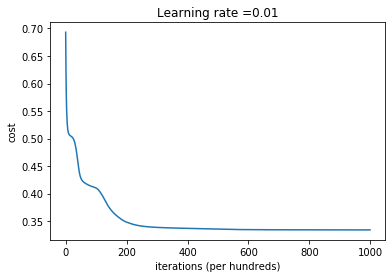

In [21]:
layer_dim = [11,4,1]
weights = L_layer_model(x_train.T,y_train.T,layer_dim)

In [22]:
def predict(parameters, X):
    A2, cache = L_model_forward(X, parameters)
    predictions = np.round(A2)
    return predictions

In [23]:
pre = predict(weights,x_test.T)

In [37]:
accuracy_score(y_test,pre.reshape((-1,1)))

0.8644